Translating TensorFlow code to PyTorch on cuda
Running for 1024 steps per rollout (PPO Standard)
Gen   0 | Avg Score: 1250.00 | Max Score: 1810.00 | PPO Loss: -0.006 | Ent: 1.773 | Val Loss: 0.176
Gen   1 | Avg Score: 1202.50 | Max Score: 1530.00 | PPO Loss: -0.008 | Ent: 1.769 | Val Loss: 0.163
Gen   2 | Avg Score: 1190.62 | Max Score: 1600.00 | PPO Loss: -0.009 | Ent: 1.768 | Val Loss: 0.158
Gen   3 | Avg Score: 1261.88 | Max Score: 1620.00 | PPO Loss: -0.010 | Ent: 1.765 | Val Loss: 0.176
Gen   4 | Avg Score: 1376.25 | Max Score: 1710.00 | PPO Loss: -0.011 | Ent: 1.766 | Val Loss: 0.161
Gen   5 | Avg Score: 1341.25 | Max Score: 1720.00 | PPO Loss: -0.010 | Ent: 1.762 | Val Loss: 0.167
Gen   6 | Avg Score: 1296.25 | Max Score: 1600.00 | PPO Loss: -0.012 | Ent: 1.758 | Val Loss: 0.149
Gen   7 | Avg Score: 1347.50 | Max Score: 1720.00 | PPO Loss: -0.012 | Ent: 1.761 | Val Loss: 0.162
Gen   8 | Avg Score: 1341.25 | Max Score: 1670.00 | PPO Loss: -0.013 | Ent: 1.755 | Val Loss: 0.175
Gen

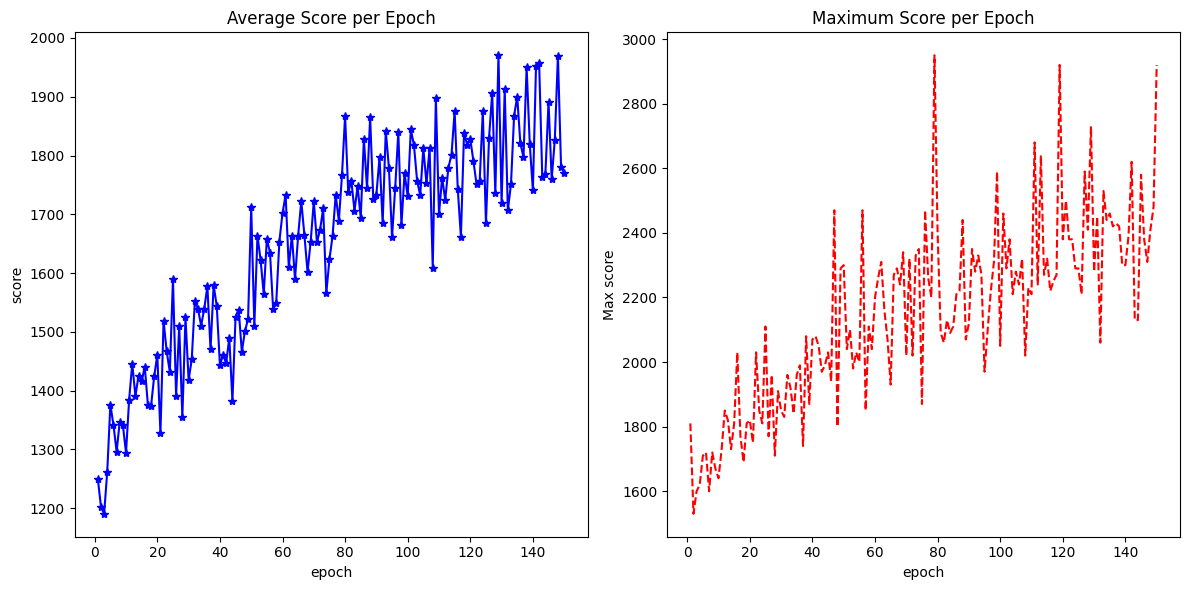

In [9]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import ale_py
import imageio
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# Register ALE environments
gym.register_envs(ale_py)

# --- Hyperparameters ---
NUM_ENVS = 16

# Note: Your TF code actually used 500 steps (Line 8 of your TF script).
# However, PPO performs better with 2048. We use 2048 here.
# To handle the memory load of 2048 * 210x160x3 images, we use pre-allocated arrays.
NUM_STEPS = 1024        

NUM_GENS = 150
LEARNING_RATE = 1.0e-4 
GAMMA = 0.99
LAMBDA = 0.95
CLIP_EPS = 0.1         
BATCH_SIZE = 32        
UPDATE_EPOCHS = 4      
ENTROPY_COEF = 0.01
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs("ppo_tf_checkpoints", exist_ok=True)

# --- Custom Dataset for Memory Efficiency ---
class AtariDataset(Dataset):
    """
    Keeps data in uint8 (CPU) to save RAM.
    Converts to float32 (GPU) only when a batch is requested.
    """
    def __init__(self, obs, act, lps, adv, ret, device):
        self.obs = obs # uint8 numpy array
        self.act = torch.tensor(act, dtype=torch.long, device=device)
        self.lps = torch.tensor(lps, dtype=torch.float32, device=device)
        self.adv = torch.tensor(adv, dtype=torch.float32, device=device)
        self.ret = torch.tensor(ret, dtype=torch.float32, device=device)
        self.device = device

    def __len__(self):
        return len(self.obs)

    def __getitem__(self, idx):
        # Convert single item/slice to float32 and move to device on the fly
        # (B, H, W, C) -> (B, C, H, W)
        o = self.obs[idx]
        o_tensor = torch.tensor(o, dtype=torch.float32, device=self.device)
        o_tensor = o_tensor.permute(2, 0, 1) / 255.0
        
        return o_tensor, self.act[idx], self.lps[idx], self.adv[idx], self.ret[idx]

# --- 1. Models (Replicating the TF 5-Layer Architecture) ---
class Actor(nn.Module):
    def __init__(self, num_actions):
        super(Actor, self).__init__()
        # TF Architecture: 5 Conv layers taking 210x160x3 input
        self.features = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=8, stride=4), nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=4, stride=2), nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2), nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2), nn.ReLU(),
            nn.Flatten()
        )
        
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 210, 160)
            flat_size = self.features(dummy).shape[1]

        self.head = nn.Sequential(
            nn.Linear(flat_size, 256),
            nn.ReLU(),
            nn.Linear(256, num_actions)
        )
        
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            nn.init.orthogonal_(module.weight, gain=np.sqrt(2))
            module.bias.data.fill_(0.0)

    def forward(self, x):
        x = self.features(x)
        return self.head(x)

class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=8, stride=4), nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=4, stride=2), nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2), nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2), nn.ReLU(),
            nn.Flatten()
        )
        
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 210, 160)
            flat_size = self.features(dummy).shape[1]

        self.head = nn.Sequential(
            nn.Linear(flat_size, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            nn.init.orthogonal_(module.weight, gain=np.sqrt(2))
            module.bias.data.fill_(0.0)

    def forward(self, x):
        x = self.features(x)
        return self.head(x)

# --- 2. Rollout Logic ---
def rollout(env, p_model, v_model, num_steps, last_obs=None, device='cpu'):
    if last_obs is None:
        obs, info = env.reset()
    else:
        obs = last_obs

    # Pre-allocate buffers to prevent memory fragmentation and spikes
    # Shape: (Steps, Envs, H, W, C) for Obs
    obs_buf = np.zeros((num_steps, NUM_ENVS, 210, 160, 3), dtype=np.uint8)
    act_buf = np.zeros((num_steps, NUM_ENVS), dtype=np.int32)
    lp_buf  = np.zeros((num_steps, NUM_ENVS), dtype=np.float32)
    val_buf = np.zeros((num_steps, NUM_ENVS), dtype=np.float32)
    rew_buf = np.zeros((num_steps, NUM_ENVS), dtype=np.float32)
    done_buf = np.zeros((num_steps, NUM_ENVS), dtype=np.float32)

    p_model.eval()
    v_model.eval()

    with torch.no_grad():
        for step in range(num_steps):
            # Normalize just for the forward pass
            obs_norm = obs.astype(np.float32) / 255.0
            obs_tensor = torch.tensor(obs_norm, dtype=torch.float32, device=device).permute(0, 3, 1, 2)
            
            logits = p_model(obs_tensor)
            dist = Categorical(logits=logits)
            actions = dist.sample()
            log_probs = dist.log_prob(actions)
            values = v_model(obs_tensor).squeeze(-1)

            nxt, reward, terminated, truncated, _ = env.step(actions.cpu().numpy())
            dones = np.logical_or(terminated, truncated).astype(np.float32)

            # Store RAW reward here for logging
            # We will clip it later for training
            obs_buf[step] = obs
            act_buf[step] = actions.cpu().numpy()
            lp_buf[step]  = log_probs.cpu().numpy()
            val_buf[step] = values.cpu().numpy()
            rew_buf[step] = reward
            done_buf[step] = dones

            obs = nxt

    return obs_buf, act_buf, lp_buf, val_buf, rew_buf, done_buf, obs

# --- 3. GAE Calculation ---
def compute_gae(values, rewards, dones, next_value, gamma, lam):
    advantages = np.zeros_like(rewards)
    last_gae_lam = 0
    values_ext = np.append(values, next_value[None, :], axis=0)
    
    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * values_ext[t+1] * (1 - dones[t]) - values_ext[t]
        last_gae_lam = delta + gamma * lam * (1 - dones[t]) * last_gae_lam
        advantages[t] = last_gae_lam
        
    returns = advantages + values
    return advantages, returns

# --- 4. Training Step ---
def train_step(p_model, v_model, p_opt, v_opt, batch):
    obs, act, old_lps, adv, ret = batch
    
    # --- Update Actor ---
    p_model.train()
    logits = p_model(obs)
    dist = Categorical(logits=logits)
    new_lps = dist.log_prob(act)
    entropy = dist.entropy().mean()

    ratio = torch.exp(new_lps - old_lps)
    surr1 = ratio * adv
    surr2 = torch.clamp(ratio, 1.0 - CLIP_EPS, 1.0 + CLIP_EPS) * adv
    ppo_loss = -torch.min(surr1, surr2).mean()
    
    policy_loss = ppo_loss - ENTROPY_COEF * entropy

    p_opt.zero_grad()
    policy_loss.backward()
    nn.utils.clip_grad_norm_(p_model.parameters(), 1.0)
    p_opt.step()

    # --- Update Critic ---
    v_model.train()
    values = v_model(obs).squeeze(-1)
    value_loss = ((ret - values) ** 2).mean()
    
    v_opt.zero_grad()
    value_loss.backward()
    nn.utils.clip_grad_norm_(v_model.parameters(), 1.0)
    v_opt.step()

    return ppo_loss.item(), entropy.item(), value_loss.item()

# --- 5. Main Loop ---
def main():
    print(f"Translating TensorFlow code to PyTorch on {DEVICE}")
    print(f"Running for {NUM_STEPS} steps per rollout (PPO Standard)")
    
    env = gym.make_vec('ALE/Galaxian-v5', frameskip=4, num_envs=NUM_ENVS, vectorization_mode='sync')
    
    p_model = Actor(env.single_action_space.n).to(DEVICE)
    v_model = Critic().to(DEVICE)
    
    p_optimizer = optim.Adam(p_model.parameters(), lr=LEARNING_RATE)
    v_optimizer = optim.Adam(v_model.parameters(), lr=LEARNING_RATE)
    
    current_obs = None
    
    # Logging Lists for Plotting
    avg_scores_history = []
    max_scores_history = []

    for gen in range(NUM_GENS):
        # 1. Rollout
        obs, act, lps, vals, raw_rew, dones, current_obs = rollout(
            env, p_model, v_model, NUM_STEPS, last_obs=current_obs, device=DEVICE
        )

        # 2. Prepare Rewards for Training
        # We use clipped rewards for GAE to prevent gradient explosion
        clipped_rew = np.sign(raw_rew)

        # 3. Bootstrap
        with torch.no_grad():
            o_norm = current_obs.astype(np.float32) / 255.0
            last_obs_tensor = torch.tensor(o_norm, dtype=torch.float32, device=DEVICE).permute(0, 3, 1, 2)
            next_val = v_model(last_obs_tensor).squeeze(-1).cpu().numpy()

        # 4. GAE (Using Clipped Rewards)
        adv, ret = compute_gae(vals, clipped_rew, dones, next_val, GAMMA, LAMBDA)
        adv = (adv - adv.mean()) / (adv.std() + 1e-8)

        # 5. Prepare Data
        # Flatten batches
        b_obs = obs.reshape(-1, 210, 160, 3) 
        b_act = act.reshape(-1)
        b_lps = lps.reshape(-1)
        b_adv = adv.reshape(-1)
        b_ret = ret.reshape(-1)

        dataset = AtariDataset(b_obs, b_act, b_lps, b_adv, b_ret, DEVICE)
        dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

        # 6. Train
        metrics = []
        for _ in range(UPDATE_EPOCHS):
            for batch in dataloader:
                metrics.append(train_step(p_model, v_model, p_optimizer, v_optimizer, batch))
        
        avg = np.mean(metrics, axis=0)
        
        # Calculate Rewards for Logging & Plotting
        # Sum over steps (Batch Score)
        total_batch_reward = np.sum(raw_rew, axis=0) # Shape: (16,)
        avg_batch_reward = np.mean(total_batch_reward)
        max_batch_reward = np.max(total_batch_reward)
        
        # Append to history
        avg_scores_history.append(avg_batch_reward)
        max_scores_history.append(max_batch_reward)

        print(f"Gen {gen:3d} | Avg Score: {avg_batch_reward:6.2f} | Max Score: {max_batch_reward:6.2f} | "
              f"PPO Loss: {avg[0]:.3f} | Ent: {avg[1]:.3f} | Val Loss: {avg[2]:.3f}")

    # Save
    torch.save(p_model.state_dict(), "ppo_atari_translated_actor.pth")
    torch.save(v_model.state_dict(), "ppo_atari_translated_critic.pth")
    
    # --- Generate Plot ---
    print("Generating Training Plot...")
    epochs = range(1, NUM_GENS + 1)
    
    plt.figure(figsize=(12, 6))
    
    # Left Subplot: Average Score
    plt.subplot(1, 2, 1)
    plt.plot(epochs, avg_scores_history, '*-b') # Blue line with stars
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('Average Score per Epoch')
    
    # Right Subplot: Max Score
    plt.subplot(1, 2, 2)
    plt.plot(epochs, max_scores_history, '--r') # Red dashed line
    plt.xlabel('epoch')
    plt.ylabel('Max score')
    plt.title('Maximum Score per Epoch')
    
    plt.tight_layout()
    plt.savefig('training_plot.png')
    print("Plot saved as 'training_plot.png'")
    
    # Render
    print("Rendering...")
    obs, _, _, _, _, _, _ = rollout(env, p_model, v_model, num_steps=1024, last_obs=None, device=DEVICE)
    to_render = obs[:, 0, ...]
    imageio.mimsave('ppo_atari_translated.gif', to_render, fps=30, loop=0)

if __name__ == "__main__":
    main()

In [10]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import ale_py
import imageio
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [1]:
# Register ALE environments
gym.register_envs(ale_py)

# --- Configuration ---
ENV_NAME = "ALE/Galaxian-v5"
NUM_ENVS = 16
GIF_STEPS = 1024
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ACTOR_PATH = "ppo_atari_translated_actor.pth"

# --- 1. Model Architecture (Must match Implementation A exactly) ---
class Actor(nn.Module):
    def __init__(self, num_actions):
        super(Actor, self).__init__()
        # TF Architecture: 5 Conv layers taking 210x160x3 input
        self.features = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=8, stride=4), nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=4, stride=2), nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2), nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2), nn.ReLU(),
            nn.Flatten()
        )
        
        # Dummy pass to calculate flat size
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 210, 160)
            flat_size = self.features(dummy).shape[1]

        self.head = nn.Sequential(
            nn.Linear(flat_size, 256),
            nn.ReLU(),
            nn.Linear(256, num_actions)
        )

    def forward(self, x):
        x = self.features(x)
        return self.head(x)

# --- 2. GIF Generation Logic ---
def generate_gif_impl_a():
    print(f"Loading Implementation A (High Res, 5-Layer CNN) from {ACTOR_PATH}...")
    
    # 1. Setup Environment
    # We use make_vec to match the training setup exactly
    env = gym.make_vec(ENV_NAME, frameskip=4, num_envs=NUM_ENVS, vectorization_mode='sync')
    
    # 2. Instantiate Model
    n_actions = env.single_action_space.n
    actor = Actor(n_actions).to(DEVICE)
    
    # 3. Load Weights
    if os.path.exists(ACTOR_PATH):
        state_dict = torch.load(ACTOR_PATH, map_location=DEVICE)
        actor.load_state_dict(state_dict)
        print("Weights loaded successfully.")
    else:
        print(f"Error: Checkpoint '{ACTOR_PATH}' not found!")
        return

    actor.eval()
    
    # 4. Run Evaluation Loop
    print(f"Collecting {GIF_STEPS} frames...")
    
    obs, info = env.reset()
    
    # Buffer for GIF frames (uint8 to save RAM)
    # Shape: (Steps, Envs, H, W, C) -> (1024, 16, 210, 160, 3)
    obs_buf = np.zeros((GIF_STEPS, NUM_ENVS, 210, 160, 3), dtype=np.uint8)
    
    with torch.no_grad():
        for step in range(GIF_STEPS):
            # Store raw frame
            obs_buf[step] = obs
            
            # Preprocess for Model: (B, H, W, C) -> Float -> Permute (B, C, H, W)
            obs_norm = obs.astype(np.float32) / 255.0
            obs_tensor = torch.tensor(obs_norm, dtype=torch.float32, device=DEVICE).permute(0, 3, 1, 2)
            
            # Get Action
            logits = actor(obs_tensor)
            dist = Categorical(logits=logits)
            actions = dist.sample()
            
            # Step Env
            obs, reward, terminated, truncated, _ = env.step(actions.cpu().numpy())

    # 5. Save GIF
    filename = "ppo_impl_a_result.gif"
    print(f"Saving GIF to {filename}...")
    
    # Render the first environment only
    to_render = obs_buf[:, 0, ...] 
    imageio.mimsave(filename, to_render, fps=30, loop=0)
    print("Done!")
    
    env.close()

NameError: name 'gym' is not defined

In [12]:
generate_gif_impl_a()

Loading Implementation A (High Res, 5-Layer CNN) from ppo_atari_translated_actor.pth...
Weights loaded successfully.
Saving GIF to ppo_impl_a_result.gif...
Done!
